<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:19:51] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


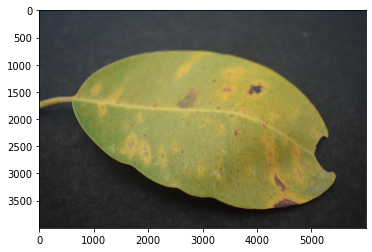

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

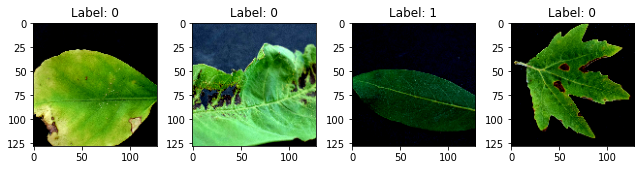

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:19:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:19:59] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2494431124190157 samples/sec                   batch loss = 0.19826218485832214 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2665735779408709 samples/sec                   batch loss = 0.7043954133987427 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.235871471905667 samples/sec                   batch loss = 0.6078014373779297 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.266929186540291 samples/sec                   batch loss = 1.3313841819763184 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2655822191646073 samples/sec                   batch loss = 1.0442290306091309 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2667336631816901 samples/sec                   batch loss = 0.4806769788265228 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2748108685098567 samples/sec                   batch loss = 0.565399169921875 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2665807493528836 samples/sec                   batch loss = 0.608659565448761 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2707590940059525 samples/sec                   batch loss = 0.4441721737384796 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2675035744168082 samples/sec                   batch loss = 0.510743260383606 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2670292673422257 samples/sec                   batch loss = 0.8890621662139893 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.266817355861456 samples/sec                   batch loss = 0.559413492679596 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2727896744607499 samples/sec                   batch loss = 0.33912068605422974 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.271708744622766 samples/sec                   batch loss = 0.7744158506393433 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2665989172934464 samples/sec                   batch loss = 1.298271894454956 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2660886920801313 samples/sec                   batch loss = 0.5022682547569275 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2756368959288493 samples/sec                   batch loss = 0.618319571018219 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2678208067897554 samples/sec                   batch loss = 1.6532238721847534 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.269337418483742 samples/sec                   batch loss = 0.5132461786270142 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2605539889517174 samples/sec                   batch loss = 0.42764905095100403 | accuracy = 0.5925


Epoch[1] Batch[105] Speed: 1.2581846003097388 samples/sec                   batch loss = 0.48566484451293945 | accuracy = 0.5928571428571429


Epoch[1] Batch[110] Speed: 1.2676752931248862 samples/sec                   batch loss = 0.38502180576324463 | accuracy = 0.5954545454545455


Epoch[1] Batch[115] Speed: 1.262214857996826 samples/sec                   batch loss = 0.9527518153190613 | accuracy = 0.5934782608695652


Epoch[1] Batch[120] Speed: 1.260910015534013 samples/sec                   batch loss = 0.4519144296646118 | accuracy = 0.5979166666666667


Epoch[1] Batch[125] Speed: 1.2600217453656288 samples/sec                   batch loss = 0.7901754975318909 | accuracy = 0.598


Epoch[1] Batch[130] Speed: 1.2720090865936882 samples/sec                   batch loss = 0.8802844285964966 | accuracy = 0.5942307692307692


Epoch[1] Batch[135] Speed: 1.270166847217256 samples/sec                   batch loss = 0.43101513385772705 | accuracy = 0.5962962962962963


Epoch[1] Batch[140] Speed: 1.2724742939155549 samples/sec                   batch loss = 0.6842890381813049 | accuracy = 0.6


Epoch[1] Batch[145] Speed: 1.2717960846741334 samples/sec                   batch loss = 0.6573526263237 | accuracy = 0.603448275862069


Epoch[1] Batch[150] Speed: 1.2668702553386149 samples/sec                   batch loss = 0.5884745717048645 | accuracy = 0.605


Epoch[1] Batch[155] Speed: 1.2640990398335634 samples/sec                   batch loss = 0.6315360069274902 | accuracy = 0.6048387096774194


Epoch[1] Batch[160] Speed: 1.2602620608238193 samples/sec                   batch loss = 0.7635186910629272 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2710811361623495 samples/sec                   batch loss = 0.4588938355445862 | accuracy = 0.6106060606060606


Epoch[1] Batch[170] Speed: 1.2770567831949804 samples/sec                   batch loss = 0.454118937253952 | accuracy = 0.6147058823529412


Epoch[1] Batch[175] Speed: 1.2756487290172096 samples/sec                   batch loss = 0.6627338528633118 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2697444536903435 samples/sec                   batch loss = 0.44064417481422424 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2687074467260517 samples/sec                   batch loss = 0.3874325156211853 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2661853910939491 samples/sec                   batch loss = 0.7642996907234192 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.269728789967145 samples/sec                   batch loss = 0.5882693529129028 | accuracy = 0.6269230769230769


Epoch[1] Batch[200] Speed: 1.267599053086912 samples/sec                   batch loss = 1.0155194997787476 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.2747066491541434 samples/sec                   batch loss = 0.23558306694030762 | accuracy = 0.6329268292682927


Epoch[1] Batch[210] Speed: 1.2679922281398295 samples/sec                   batch loss = 0.695158064365387 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2706351344381615 samples/sec                   batch loss = 0.7139341831207275 | accuracy = 0.6360465116279069


Epoch[1] Batch[220] Speed: 1.268751005319278 samples/sec                   batch loss = 0.5136728286743164 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2698249886260657 samples/sec                   batch loss = 0.3015848398208618 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2769757171469365 samples/sec                   batch loss = 1.0212405920028687 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.2701108836358876 samples/sec                   batch loss = 0.4184810519218445 | accuracy = 0.6372340425531915


Epoch[1] Batch[240] Speed: 1.2746955114762908 samples/sec                   batch loss = 0.5963571071624756 | accuracy = 0.6354166666666666


Epoch[1] Batch[245] Speed: 1.2734785137330027 samples/sec                   batch loss = 0.652054488658905 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2775127526904368 samples/sec                   batch loss = 0.7595245838165283 | accuracy = 0.643


Epoch[1] Batch[255] Speed: 1.2745898584917308 samples/sec                   batch loss = 1.3737958669662476 | accuracy = 0.6421568627450981


Epoch[1] Batch[260] Speed: 1.2592416126071153 samples/sec                   batch loss = 0.5621445178985596 | accuracy = 0.6432692307692308


Epoch[1] Batch[265] Speed: 1.263674580078593 samples/sec                   batch loss = 0.9223589301109314 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2636391737109796 samples/sec                   batch loss = 0.2643907368183136 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.2579050860338419 samples/sec                   batch loss = 0.43255478143692017 | accuracy = 0.6463636363636364


Epoch[1] Batch[280] Speed: 1.2638887737958255 samples/sec                   batch loss = 0.6466992497444153 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2775912601302841 samples/sec                   batch loss = 0.4197370409965515 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.260111651800565 samples/sec                   batch loss = 1.1631444692611694 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2627349853922176 samples/sec                   batch loss = 0.3795001804828644 | accuracy = 0.6474576271186441


Epoch[1] Batch[300] Speed: 1.2656712022129837 samples/sec                   batch loss = 0.7304670214653015 | accuracy = 0.6475


Epoch[1] Batch[305] Speed: 1.2657121653538823 samples/sec                   batch loss = 0.2986524999141693 | accuracy = 0.6508196721311476


Epoch[1] Batch[310] Speed: 1.264859266333773 samples/sec                   batch loss = 0.7184809446334839 | accuracy = 0.6532258064516129


Epoch[1] Batch[315] Speed: 1.259941219020429 samples/sec                   batch loss = 0.6529521942138672 | accuracy = 0.6531746031746032


Epoch[1] Batch[320] Speed: 1.272148362269401 samples/sec                   batch loss = 1.1818474531173706 | accuracy = 0.653125


Epoch[1] Batch[325] Speed: 1.274628689496183 samples/sec                   batch loss = 0.40799203515052795 | accuracy = 0.6553846153846153


Epoch[1] Batch[330] Speed: 1.2622371742983622 samples/sec                   batch loss = 0.47033601999282837 | accuracy = 0.6568181818181819


Epoch[1] Batch[335] Speed: 1.2639992309269816 samples/sec                   batch loss = 0.694855272769928 | accuracy = 0.6559701492537313


Epoch[1] Batch[340] Speed: 1.2641128505132901 samples/sec                   batch loss = 0.3883618116378784 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2577834328281672 samples/sec                   batch loss = 0.15773840248584747 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2613195336012115 samples/sec                   batch loss = 0.6658359169960022 | accuracy = 0.6578571428571428


Epoch[1] Batch[355] Speed: 1.2626580080213914 samples/sec                   batch loss = 0.778613805770874 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2658995410692229 samples/sec                   batch loss = 1.080225944519043 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.2721886846047739 samples/sec                   batch loss = 0.8530036211013794 | accuracy = 0.660958904109589


Epoch[1] Batch[370] Speed: 1.2633096660657044 samples/sec                   batch loss = 0.8098118305206299 | accuracy = 0.6614864864864864


Epoch[1] Batch[375] Speed: 1.265824087499105 samples/sec                   batch loss = 0.5488671660423279 | accuracy = 0.6633333333333333


Epoch[1] Batch[380] Speed: 1.2646854496333462 samples/sec                   batch loss = 0.7571028470993042 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2561246048783907 samples/sec                   batch loss = 0.529582142829895 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.2618143433734916 samples/sec                   batch loss = 0.22849324345588684 | accuracy = 0.6653846153846154


Epoch[1] Batch[395] Speed: 1.2635929199940652 samples/sec                   batch loss = 0.560264527797699 | accuracy = 0.6658227848101266


Epoch[1] Batch[400] Speed: 1.2640071350653004 samples/sec                   batch loss = 0.5161295533180237 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.2651155495531772 samples/sec                   batch loss = 0.7347521185874939 | accuracy = 0.667283950617284


Epoch[1] Batch[410] Speed: 1.2667601566965991 samples/sec                   batch loss = 0.8670480251312256 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.2699113011264802 samples/sec                   batch loss = 0.4504763185977936 | accuracy = 0.6698795180722892


Epoch[1] Batch[420] Speed: 1.2680243328748895 samples/sec                   batch loss = 1.1524726152420044 | accuracy = 0.6684523809523809


Epoch[1] Batch[425] Speed: 1.26495224879934 samples/sec                   batch loss = 0.339682936668396 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2670260139891405 samples/sec                   batch loss = 0.9228656888008118 | accuracy = 0.6656976744186046


Epoch[1] Batch[435] Speed: 1.2668533231988386 samples/sec                   batch loss = 0.23166172206401825 | accuracy = 0.6660919540229885


Epoch[1] Batch[440] Speed: 1.2668743688646356 samples/sec                   batch loss = 0.3781103491783142 | accuracy = 0.6659090909090909


Epoch[1] Batch[445] Speed: 1.2656788408260173 samples/sec                   batch loss = 0.5431327223777771 | accuracy = 0.6674157303370787


Epoch[1] Batch[450] Speed: 1.2679777575818267 samples/sec                   batch loss = 0.668512225151062 | accuracy = 0.6672222222222223


Epoch[1] Batch[455] Speed: 1.2711067525000561 samples/sec                   batch loss = 0.6535763740539551 | accuracy = 0.667032967032967


Epoch[1] Batch[460] Speed: 1.2702704216983047 samples/sec                   batch loss = 1.2606040239334106 | accuracy = 0.6657608695652174


Epoch[1] Batch[465] Speed: 1.2677207924917318 samples/sec                   batch loss = 0.832412838935852 | accuracy = 0.6645161290322581


Epoch[1] Batch[470] Speed: 1.262686802161344 samples/sec                   batch loss = 0.7100275158882141 | accuracy = 0.6648936170212766


Epoch[1] Batch[475] Speed: 1.2736027386850883 samples/sec                   batch loss = 0.5104861855506897 | accuracy = 0.6657894736842105


Epoch[1] Batch[480] Speed: 1.2584259144941465 samples/sec                   batch loss = 0.45745936036109924 | accuracy = 0.6645833333333333


Epoch[1] Batch[485] Speed: 1.264212391578436 samples/sec                   batch loss = 1.0003269910812378 | accuracy = 0.6639175257731958


Epoch[1] Batch[490] Speed: 1.2692897863925594 samples/sec                   batch loss = 0.8524516224861145 | accuracy = 0.6642857142857143


Epoch[1] Batch[495] Speed: 1.268740451200554 samples/sec                   batch loss = 0.6704908609390259 | accuracy = 0.6641414141414141


Epoch[1] Batch[500] Speed: 1.2635832128537527 samples/sec                   batch loss = 0.5683659315109253 | accuracy = 0.665


Epoch[1] Batch[505] Speed: 1.2675588296269344 samples/sec                   batch loss = 0.5726386904716492 | accuracy = 0.6653465346534654


Epoch[1] Batch[510] Speed: 1.2623111561077407 samples/sec                   batch loss = 0.5839741826057434 | accuracy = 0.6647058823529411


Epoch[1] Batch[515] Speed: 1.2628387771494234 samples/sec                   batch loss = 0.44005367159843445 | accuracy = 0.6640776699029126


Epoch[1] Batch[520] Speed: 1.2633964270371036 samples/sec                   batch loss = 0.8119487762451172 | accuracy = 0.6634615384615384


Epoch[1] Batch[525] Speed: 1.262827560734359 samples/sec                   batch loss = 0.6774530410766602 | accuracy = 0.6638095238095238


Epoch[1] Batch[530] Speed: 1.2738203115728772 samples/sec                   batch loss = 0.3652670979499817 | accuracy = 0.6627358490566038


Epoch[1] Batch[535] Speed: 1.2664131507805585 samples/sec                   batch loss = 0.5263195037841797 | accuracy = 0.664018691588785


Epoch[1] Batch[540] Speed: 1.2691316466008975 samples/sec                   batch loss = 0.2840362787246704 | accuracy = 0.6643518518518519


Epoch[1] Batch[545] Speed: 1.2637561555250487 samples/sec                   batch loss = 0.6894287467002869 | accuracy = 0.6651376146788991


Epoch[1] Batch[550] Speed: 1.2632663851680266 samples/sec                   batch loss = 0.2722092866897583 | accuracy = 0.6654545454545454


Epoch[1] Batch[555] Speed: 1.2647546654802033 samples/sec                   batch loss = 0.41268450021743774 | accuracy = 0.6671171171171171


Epoch[1] Batch[560] Speed: 1.261430395682696 samples/sec                   batch loss = 0.4995349645614624 | accuracy = 0.6674107142857143


Epoch[1] Batch[565] Speed: 1.2706772856767952 samples/sec                   batch loss = 0.4260817766189575 | accuracy = 0.6672566371681415


Epoch[1] Batch[570] Speed: 1.265211145841063 samples/sec                   batch loss = 0.47812420129776 | accuracy = 0.6684210526315789


Epoch[1] Batch[575] Speed: 1.2561038208064477 samples/sec                   batch loss = 0.4176391065120697 | accuracy = 0.6704347826086956


Epoch[1] Batch[580] Speed: 1.266414106721925 samples/sec                   batch loss = 0.6249768733978271 | accuracy = 0.6706896551724137


Epoch[1] Batch[585] Speed: 1.2638549739627531 samples/sec                   batch loss = 0.22887715697288513 | accuracy = 0.6726495726495727


Epoch[1] Batch[590] Speed: 1.2597092547080249 samples/sec                   batch loss = 0.6017647981643677 | accuracy = 0.6724576271186441


Epoch[1] Batch[595] Speed: 1.2631117396431741 samples/sec                   batch loss = 0.35320845246315 | accuracy = 0.6735294117647059


Epoch[1] Batch[600] Speed: 1.2701497306843315 samples/sec                   batch loss = 0.4158276915550232 | accuracy = 0.6741666666666667


Epoch[1] Batch[605] Speed: 1.2616403188494096 samples/sec                   batch loss = 0.7500243186950684 | accuracy = 0.6735537190082644


Epoch[1] Batch[610] Speed: 1.2733369171799758 samples/sec                   batch loss = 0.39600157737731934 | accuracy = 0.6733606557377049


Epoch[1] Batch[615] Speed: 1.2667153957356856 samples/sec                   batch loss = 0.9610524773597717 | accuracy = 0.6743902439024391


Epoch[1] Batch[620] Speed: 1.2686200507290255 samples/sec                   batch loss = 0.4324342906475067 | accuracy = 0.6741935483870968


Epoch[1] Batch[625] Speed: 1.2669965431988377 samples/sec                   batch loss = 0.38711801171302795 | accuracy = 0.6744


Epoch[1] Batch[630] Speed: 1.2653829119919677 samples/sec                   batch loss = 0.3009541928768158 | accuracy = 0.6761904761904762


Epoch[1] Batch[635] Speed: 1.2657686969329138 samples/sec                   batch loss = 1.0719605684280396 | accuracy = 0.6748031496062992


Epoch[1] Batch[640] Speed: 1.2646844009666567 samples/sec                   batch loss = 0.4392305314540863 | accuracy = 0.674609375


Epoch[1] Batch[645] Speed: 1.2670516585195875 samples/sec                   batch loss = 0.4949527382850647 | accuracy = 0.6755813953488372


Epoch[1] Batch[650] Speed: 1.263304719527298 samples/sec                   batch loss = 0.48343124985694885 | accuracy = 0.6765384615384615


Epoch[1] Batch[655] Speed: 1.2726041148495066 samples/sec                   batch loss = 0.7786473035812378 | accuracy = 0.6759541984732824


Epoch[1] Batch[660] Speed: 1.2668848919597528 samples/sec                   batch loss = 0.3247127830982208 | accuracy = 0.6768939393939394


Epoch[1] Batch[665] Speed: 1.2670389318131579 samples/sec                   batch loss = 0.2830028533935547 | accuracy = 0.6774436090225564


Epoch[1] Batch[670] Speed: 1.2610180569718474 samples/sec                   batch loss = 0.6641457080841064 | accuracy = 0.6779850746268656


Epoch[1] Batch[675] Speed: 1.2617655661187255 samples/sec                   batch loss = 0.4395397901535034 | accuracy = 0.6777777777777778


Epoch[1] Batch[680] Speed: 1.2661577749478623 samples/sec                   batch loss = 0.4635845422744751 | accuracy = 0.6786764705882353


Epoch[1] Batch[685] Speed: 1.262584270601506 samples/sec                   batch loss = 0.439709335565567 | accuracy = 0.6784671532846716


Epoch[1] Batch[690] Speed: 1.2604062562284204 samples/sec                   batch loss = 0.46698594093322754 | accuracy = 0.6793478260869565


Epoch[1] Batch[695] Speed: 1.2639729479971895 samples/sec                   batch loss = 0.43044841289520264 | accuracy = 0.6802158273381295


Epoch[1] Batch[700] Speed: 1.260583729084306 samples/sec                   batch loss = 0.6458316445350647 | accuracy = 0.6814285714285714


Epoch[1] Batch[705] Speed: 1.264139996521908 samples/sec                   batch loss = 0.32383936643600464 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.2593890724238854 samples/sec                   batch loss = 0.39580225944519043 | accuracy = 0.6820422535211268


Epoch[1] Batch[715] Speed: 1.2623053626107361 samples/sec                   batch loss = 0.20533256232738495 | accuracy = 0.6828671328671329


Epoch[1] Batch[720] Speed: 1.2676187826694558 samples/sec                   batch loss = 0.6119003891944885 | accuracy = 0.6822916666666666


Epoch[1] Batch[725] Speed: 1.265158671040207 samples/sec                   batch loss = 0.4108211398124695 | accuracy = 0.6827586206896552


Epoch[1] Batch[730] Speed: 1.2644146653934003 samples/sec                   batch loss = 0.48089784383773804 | accuracy = 0.6825342465753425


Epoch[1] Batch[735] Speed: 1.2678810720647764 samples/sec                   batch loss = 0.280118465423584 | accuracy = 0.6829931972789116


Epoch[1] Batch[740] Speed: 1.2681913995703156 samples/sec                   batch loss = 0.4594235122203827 | accuracy = 0.6831081081081081


Epoch[1] Batch[745] Speed: 1.2676939714171445 samples/sec                   batch loss = 0.5667695999145508 | accuracy = 0.6835570469798657


Epoch[1] Batch[750] Speed: 1.2751616201131373 samples/sec                   batch loss = 0.42795899510383606 | accuracy = 0.684


Epoch[1] Batch[755] Speed: 1.2681691598111429 samples/sec                   batch loss = 0.44031962752342224 | accuracy = 0.6847682119205298


Epoch[1] Batch[760] Speed: 1.2679673121524981 samples/sec                   batch loss = 0.5261010527610779 | accuracy = 0.6851973684210526


Epoch[1] Batch[765] Speed: 1.2612439612999975 samples/sec                   batch loss = 0.5768133997917175 | accuracy = 0.6843137254901961


Epoch[1] Batch[770] Speed: 1.2715238855002065 samples/sec                   batch loss = 0.3797396719455719 | accuracy = 0.6840909090909091


Epoch[1] Batch[775] Speed: 1.26767941188049 samples/sec                   batch loss = 0.7562534213066101 | accuracy = 0.6845161290322581


Epoch[1] Batch[780] Speed: 1.2689263253177532 samples/sec                   batch loss = 0.4993596374988556 | accuracy = 0.6842948717948718


Epoch[1] Batch[785] Speed: 1.26656047837125 samples/sec                   batch loss = 0.5801844000816345 | accuracy = 0.6853503184713375


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 649.9469048976898
[Epoch 1] validation: validation accuracy=0.7233333333333334


Epoch[2] Batch[5] Speed: 1.2676406200108592 samples/sec                   batch loss = 0.2374953031539917 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2680685154817706 samples/sec                   batch loss = 0.5871304273605347 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2659412831742218 samples/sec                   batch loss = 0.7301658391952515 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.264462694685519 samples/sec                   batch loss = 0.5250324606895447 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2647121435528177 samples/sec                   batch loss = 0.47680073976516724 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2674233336604401 samples/sec                   batch loss = 0.273001104593277 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2718441943072722 samples/sec                   batch loss = 0.44001537561416626 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2724081871135688 samples/sec                   batch loss = 0.38653504848480225 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2668180254474846 samples/sec                   batch loss = 0.21085089445114136 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.267104386169957 samples/sec                   batch loss = 0.4213445782661438 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2654605083273651 samples/sec                   batch loss = 0.4132247567176819 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.268742466064204 samples/sec                   batch loss = 0.8693954944610596 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2658498744163618 samples/sec                   batch loss = 0.7364723682403564 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.262493535983876 samples/sec                   batch loss = 0.45052698254585266 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2657416719163175 samples/sec                   batch loss = 0.6687976717948914 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2646375940702022 samples/sec                   batch loss = 0.4053959846496582 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.264105802266621 samples/sec                   batch loss = 0.5924332141876221 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2642235373433954 samples/sec                   batch loss = 0.9147064089775085 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2687501417938778 samples/sec                   batch loss = 0.48140957951545715 | accuracy = 0.7263157894736842


Epoch[2] Batch[100] Speed: 1.2662206535990332 samples/sec                   batch loss = 0.1690191775560379 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2695275983438012 samples/sec                   batch loss = 0.3418997824192047 | accuracy = 0.7214285714285714


Epoch[2] Batch[110] Speed: 1.267651060058323 samples/sec                   batch loss = 0.4377152919769287 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2656255634213047 samples/sec                   batch loss = 0.5154390931129456 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.2633392509790622 samples/sec                   batch loss = 0.3920663297176361 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.2684738740237254 samples/sec                   batch loss = 0.39463871717453003 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2697739563533972 samples/sec                   batch loss = 0.7437608242034912 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2655675171615444 samples/sec                   batch loss = 0.41311731934547424 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.263867731997198 samples/sec                   batch loss = 0.33868372440338135 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2669731015037267 samples/sec                   batch loss = 0.9591100215911865 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2743606972380674 samples/sec                   batch loss = 0.8988050818443298 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.275706054708737 samples/sec                   batch loss = 0.1788351982831955 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2769809657161246 samples/sec                   batch loss = 1.3865320682525635 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2653621067204592 samples/sec                   batch loss = 0.7069874405860901 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.264112945760405 samples/sec                   batch loss = 0.5387963056564331 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.2689967740349524 samples/sec                   batch loss = 0.4710858464241028 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.2740720152397615 samples/sec                   batch loss = 0.6213356256484985 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2748983445608355 samples/sec                   batch loss = 0.4321189522743225 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2754351852436094 samples/sec                   batch loss = 1.4674975872039795 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.272434435999579 samples/sec                   batch loss = 0.16859199106693268 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2737900403155393 samples/sec                   batch loss = 0.24581554532051086 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.2691661133001177 samples/sec                   batch loss = 0.5726151466369629 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2719572035921847 samples/sec                   batch loss = 0.6404879093170166 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2695043510818003 samples/sec                   batch loss = 0.5369055271148682 | accuracy = 0.7546511627906977


Epoch[2] Batch[220] Speed: 1.2696795910923024 samples/sec                   batch loss = 0.45995500683784485 | accuracy = 0.7545454545454545


Epoch[2] Batch[225] Speed: 1.2683330046056898 samples/sec                   batch loss = 0.5964889526367188 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2675044362461863 samples/sec                   batch loss = 0.2282053530216217 | accuracy = 0.7565217391304347


Epoch[2] Batch[235] Speed: 1.2725681098097528 samples/sec                   batch loss = 0.6427831649780273 | accuracy = 0.7574468085106383


Epoch[2] Batch[240] Speed: 1.2750973658105933 samples/sec                   batch loss = 0.7343016862869263 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2655102398879288 samples/sec                   batch loss = 1.1910388469696045 | accuracy = 0.7571428571428571


Epoch[2] Batch[250] Speed: 1.2715788171657367 samples/sec                   batch loss = 1.4231716394424438 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.2716678743705032 samples/sec                   batch loss = 0.5808457732200623 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.270535445377259 samples/sec                   batch loss = 0.45904117822647095 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2687357498769243 samples/sec                   batch loss = 0.8523869514465332 | accuracy = 0.7471698113207547


Epoch[2] Batch[270] Speed: 1.2758093703596425 samples/sec                   batch loss = 0.37326517701148987 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.2738820191024414 samples/sec                   batch loss = 0.3296484351158142 | accuracy = 0.7490909090909091


Epoch[2] Batch[280] Speed: 1.2631761231239418 samples/sec                   batch loss = 0.8822481036186218 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.2639539983020427 samples/sec                   batch loss = 0.4893922209739685 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2652147715335242 samples/sec                   batch loss = 0.5955035090446472 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.2666447219412023 samples/sec                   batch loss = 1.2371835708618164 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.2667460011789187 samples/sec                   batch loss = 0.5564656257629395 | accuracy = 0.7441666666666666


Epoch[2] Batch[305] Speed: 1.2684857664074636 samples/sec                   batch loss = 0.10729076713323593 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2622209355496936 samples/sec                   batch loss = 1.0447849035263062 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.265539546111867 samples/sec                   batch loss = 1.5005511045455933 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.26768707475283 samples/sec                   batch loss = 0.22498200833797455 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.2669572190522478 samples/sec                   batch loss = 0.414977490901947 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.2650130047272439 samples/sec                   batch loss = 0.5796622037887573 | accuracy = 0.7439393939393939


Epoch[2] Batch[335] Speed: 1.2649510089432099 samples/sec                   batch loss = 0.7521713972091675 | accuracy = 0.7432835820895523


Epoch[2] Batch[340] Speed: 1.2666688209146473 samples/sec                   batch loss = 0.5830774903297424 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2675168850234877 samples/sec                   batch loss = 0.7714065909385681 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.2687947588114759 samples/sec                   batch loss = 0.8831728100776672 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.2707666016508923 samples/sec                   batch loss = 0.5424363613128662 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.2655179720171532 samples/sec                   batch loss = 0.959579586982727 | accuracy = 0.7423611111111111


Epoch[2] Batch[365] Speed: 1.2727081837640424 samples/sec                   batch loss = 0.39753013849258423 | accuracy = 0.7417808219178083


Epoch[2] Batch[370] Speed: 1.2666071408484187 samples/sec                   batch loss = 0.4838278293609619 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2684230461871817 samples/sec                   batch loss = 0.5014787912368774 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2657071044959523 samples/sec                   batch loss = 0.6301003098487854 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2674038973924466 samples/sec                   batch loss = 0.5666147470474243 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.2687151220320052 samples/sec                   batch loss = 0.15672855079174042 | accuracy = 0.7403846153846154


Epoch[2] Batch[395] Speed: 1.264585262152152 samples/sec                   batch loss = 0.3820452094078064 | accuracy = 0.7398734177215189


Epoch[2] Batch[400] Speed: 1.262969016216488 samples/sec                   batch loss = 0.6702401638031006 | accuracy = 0.73625


Epoch[2] Batch[405] Speed: 1.266091462893742 samples/sec                   batch loss = 0.2504064738750458 | accuracy = 0.7364197530864197


Epoch[2] Batch[410] Speed: 1.2642865098440057 samples/sec                   batch loss = 0.27674707770347595 | accuracy = 0.7371951219512195


Epoch[2] Batch[415] Speed: 1.271756944050692 samples/sec                   batch loss = 0.704224705696106 | accuracy = 0.7367469879518073


Epoch[2] Batch[420] Speed: 1.2699228359796595 samples/sec                   batch loss = 0.3148956298828125 | accuracy = 0.7375


Epoch[2] Batch[425] Speed: 1.2675322069312425 samples/sec                   batch loss = 0.3621409237384796 | accuracy = 0.7370588235294118


Epoch[2] Batch[430] Speed: 1.2697835666373867 samples/sec                   batch loss = 0.6762223243713379 | accuracy = 0.7377906976744186


Epoch[2] Batch[435] Speed: 1.264573538108647 samples/sec                   batch loss = 0.6416609883308411 | accuracy = 0.7402298850574712


Epoch[2] Batch[440] Speed: 1.266052577067138 samples/sec                   batch loss = 0.828384518623352 | accuracy = 0.7392045454545455


Epoch[2] Batch[445] Speed: 1.2697066884384087 samples/sec                   batch loss = 0.754479706287384 | accuracy = 0.7387640449438202


Epoch[2] Batch[450] Speed: 1.2604095703649123 samples/sec                   batch loss = 0.5626233816146851 | accuracy = 0.7372222222222222


Epoch[2] Batch[455] Speed: 1.2691316466008975 samples/sec                   batch loss = 0.3389075696468353 | accuracy = 0.7373626373626374


Epoch[2] Batch[460] Speed: 1.2670247700644348 samples/sec                   batch loss = 0.0914817526936531 | accuracy = 0.7375


Epoch[2] Batch[465] Speed: 1.268351606397998 samples/sec                   batch loss = 0.8332105278968811 | accuracy = 0.7370967741935484


Epoch[2] Batch[470] Speed: 1.266100730875669 samples/sec                   batch loss = 0.5888069272041321 | accuracy = 0.7351063829787234


Epoch[2] Batch[475] Speed: 1.2652970230871312 samples/sec                   batch loss = 0.43859532475471497 | accuracy = 0.7347368421052631


Epoch[2] Batch[480] Speed: 1.2693231092742465 samples/sec                   batch loss = 0.44522255659103394 | accuracy = 0.7369791666666666


Epoch[2] Batch[485] Speed: 1.2681858395573946 samples/sec                   batch loss = 0.828235387802124 | accuracy = 0.7371134020618557


Epoch[2] Batch[490] Speed: 1.2777961837364542 samples/sec                   batch loss = 0.32052168250083923 | accuracy = 0.7362244897959184


Epoch[2] Batch[495] Speed: 1.2700714620804483 samples/sec                   batch loss = 0.5468911528587341 | accuracy = 0.7358585858585859


Epoch[2] Batch[500] Speed: 1.2640426572928152 samples/sec                   batch loss = 0.5812475085258484 | accuracy = 0.737


Epoch[2] Batch[505] Speed: 1.267567352956487 samples/sec                   batch loss = 0.4126628041267395 | accuracy = 0.7391089108910891


Epoch[2] Batch[510] Speed: 1.267147834754932 samples/sec                   batch loss = 0.3892771899700165 | accuracy = 0.7401960784313726


Epoch[2] Batch[515] Speed: 1.2649083784455812 samples/sec                   batch loss = 0.11279603093862534 | accuracy = 0.7402912621359223


Epoch[2] Batch[520] Speed: 1.2645982255752786 samples/sec                   batch loss = 0.7909669876098633 | accuracy = 0.7399038461538462


Epoch[2] Batch[525] Speed: 1.2673076822844571 samples/sec                   batch loss = 0.7615376710891724 | accuracy = 0.74


Epoch[2] Batch[530] Speed: 1.2671218992279092 samples/sec                   batch loss = 0.3577042818069458 | accuracy = 0.7405660377358491


Epoch[2] Batch[535] Speed: 1.2693475983862235 samples/sec                   batch loss = 0.37462565302848816 | accuracy = 0.741588785046729


Epoch[2] Batch[540] Speed: 1.263259821950199 samples/sec                   batch loss = 0.7990580201148987 | accuracy = 0.7421296296296296


Epoch[2] Batch[545] Speed: 1.264028371974719 samples/sec                   batch loss = 0.32684722542762756 | accuracy = 0.7440366972477064


Epoch[2] Batch[550] Speed: 1.271126206198155 samples/sec                   batch loss = 0.4202403724193573 | accuracy = 0.745


Epoch[2] Batch[555] Speed: 1.2647880367081588 samples/sec                   batch loss = 0.19108693301677704 | accuracy = 0.7450450450450451


Epoch[2] Batch[560] Speed: 1.2622145731129715 samples/sec                   batch loss = 0.27126917243003845 | accuracy = 0.7455357142857143


Epoch[2] Batch[565] Speed: 1.2662133907002553 samples/sec                   batch loss = 0.36171093583106995 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.2683614828290697 samples/sec                   batch loss = 0.4809449017047882 | accuracy = 0.7447368421052631


Epoch[2] Batch[575] Speed: 1.267169177331763 samples/sec                   batch loss = 0.41454634070396423 | accuracy = 0.7447826086956522


Epoch[2] Batch[580] Speed: 1.274536215559686 samples/sec                   batch loss = 0.4910251498222351 | accuracy = 0.7435344827586207


Epoch[2] Batch[585] Speed: 1.2634942376834244 samples/sec                   batch loss = 0.579730749130249 | accuracy = 0.7435897435897436


Epoch[2] Batch[590] Speed: 1.2631750769587997 samples/sec                   batch loss = 0.7183042168617249 | accuracy = 0.7432203389830508


Epoch[2] Batch[595] Speed: 1.2668937888947318 samples/sec                   batch loss = 0.6129959225654602 | accuracy = 0.7436974789915967


Epoch[2] Batch[600] Speed: 1.2646595194762746 samples/sec                   batch loss = 0.7651189565658569 | accuracy = 0.7433333333333333


Epoch[2] Batch[605] Speed: 1.271054846784065 samples/sec                   batch loss = 0.3807174563407898 | accuracy = 0.7446280991735538


Epoch[2] Batch[610] Speed: 1.2671308951945113 samples/sec                   batch loss = 0.14667150378227234 | accuracy = 0.7454918032786885


Epoch[2] Batch[615] Speed: 1.2567073089431735 samples/sec                   batch loss = 0.541097104549408 | accuracy = 0.7459349593495935


Epoch[2] Batch[620] Speed: 1.2683716470837807 samples/sec                   batch loss = 0.4169827699661255 | accuracy = 0.7455645161290323


Epoch[2] Batch[625] Speed: 1.2617528504891382 samples/sec                   batch loss = 0.3192817270755768 | accuracy = 0.7456


Epoch[2] Batch[630] Speed: 1.2640320861263623 samples/sec                   batch loss = 0.6297451257705688 | accuracy = 0.7456349206349207


Epoch[2] Batch[635] Speed: 1.265854172338051 samples/sec                   batch loss = 0.3571541905403137 | accuracy = 0.7460629921259843


Epoch[2] Batch[640] Speed: 1.2712998712803667 samples/sec                   batch loss = 0.8253012299537659 | accuracy = 0.74609375


Epoch[2] Batch[645] Speed: 1.2679758409763977 samples/sec                   batch loss = 0.531128466129303 | accuracy = 0.7461240310077519


Epoch[2] Batch[650] Speed: 1.2652728808611255 samples/sec                   batch loss = 0.0984099730849266 | accuracy = 0.7469230769230769


Epoch[2] Batch[655] Speed: 1.2653869204256327 samples/sec                   batch loss = 0.36652323603630066 | accuracy = 0.7469465648854962


Epoch[2] Batch[660] Speed: 1.2743478232798482 samples/sec                   batch loss = 0.43678808212280273 | accuracy = 0.7465909090909091


Epoch[2] Batch[665] Speed: 1.2766743855631804 samples/sec                   batch loss = 0.30217936635017395 | accuracy = 0.7477443609022556


Epoch[2] Batch[670] Speed: 1.270541026011715 samples/sec                   batch loss = 0.4778401255607605 | accuracy = 0.7485074626865672


Epoch[2] Batch[675] Speed: 1.2716788628121987 samples/sec                   batch loss = 0.3869323134422302 | accuracy = 0.7492592592592593


Epoch[2] Batch[680] Speed: 1.2691994296884144 samples/sec                   batch loss = 0.4204317033290863 | accuracy = 0.75


Epoch[2] Batch[685] Speed: 1.2595123602088405 samples/sec                   batch loss = 0.04483162984251976 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.259189064762629 samples/sec                   batch loss = 0.7408549189567566 | accuracy = 0.7507246376811594


Epoch[2] Batch[695] Speed: 1.2665643030351026 samples/sec                   batch loss = 0.6972713470458984 | accuracy = 0.7517985611510791


Epoch[2] Batch[700] Speed: 1.2663599071252416 samples/sec                   batch loss = 0.467959463596344 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.265567899027433 samples/sec                   batch loss = 0.4688869118690491 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.267542453663749 samples/sec                   batch loss = 0.24447941780090332 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.266369370212586 samples/sec                   batch loss = 0.5274444222450256 | accuracy = 0.7545454545454545


Epoch[2] Batch[720] Speed: 1.274507943484805 samples/sec                   batch loss = 0.5642193555831909 | accuracy = 0.7552083333333334


Epoch[2] Batch[725] Speed: 1.2703140876828745 samples/sec                   batch loss = 0.29834040999412537 | accuracy = 0.7551724137931034


Epoch[2] Batch[730] Speed: 1.2751141313918386 samples/sec                   batch loss = 0.4012662172317505 | accuracy = 0.7565068493150685


Epoch[2] Batch[735] Speed: 1.2716400185578074 samples/sec                   batch loss = 0.10521447658538818 | accuracy = 0.7571428571428571


Epoch[2] Batch[740] Speed: 1.2761089348076993 samples/sec                   batch loss = 0.6090760827064514 | accuracy = 0.7564189189189189


Epoch[2] Batch[745] Speed: 1.2797774800966537 samples/sec                   batch loss = 0.20392031967639923 | accuracy = 0.7563758389261745


Epoch[2] Batch[750] Speed: 1.2711034781737742 samples/sec                   batch loss = 0.5004188418388367 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.269778953682917 samples/sec                   batch loss = 0.6518517136573792 | accuracy = 0.7552980132450331


Epoch[2] Batch[760] Speed: 1.2692852730532096 samples/sec                   batch loss = 0.21405087411403656 | accuracy = 0.7555921052631579


Epoch[2] Batch[765] Speed: 1.2673421457185243 samples/sec                   batch loss = 0.8983178734779358 | accuracy = 0.7555555555555555


Epoch[2] Batch[770] Speed: 1.2726074934430496 samples/sec                   batch loss = 0.7460441589355469 | accuracy = 0.7561688311688312


Epoch[2] Batch[775] Speed: 1.2703831514697925 samples/sec                   batch loss = 0.06841618567705154 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.26810359540571 samples/sec                   batch loss = 0.8814569711685181 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2714440984821833 samples/sec                   batch loss = 0.5705059766769409 | accuracy = 0.7573248407643313


[Epoch 2] training: accuracy=0.756979695431472
[Epoch 2] time cost: 639.0419659614563
[Epoch 2] validation: validation accuracy=0.76


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.76

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)